## Preparing Electorial Results

In [14]:
import pandas as pd
import numpy as np
import csv
from fuzzywuzzy import fuzz
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
%matplotlib inline

For the final plot: Each party has its specific color

In [15]:
color_dict = {"Sonstige": "grey",
            "DIE LINKE" :  "#96276E",
            "FDP":"#F6BB00",
            "AfD":"#34A3D2",
            "SPD":"#DB4240",
            "CSU":"#373737",
            "CDU":"#373737",
            "CDU/CSU": '#373737',
            "GRÜNE":"#4BA345",
            "PIRATE": "#FF8800"}

Wahltraud uses abbreviations of party names. kerg.csv uses long version. Thus, we take *btw_parteien.csv* as abbreviation mapping.

In [16]:
# abbreviation - mapping
party_abbrv = pd.read_csv('btw17_parteien.csv', delimiter = ';')
long_names = list(party_abbrv['BEZEICHNUNG'].unique())

The provided file *kerg.csv* is not really machine readable. Thus we have to take out some rows and combine other fields to create a unique header for each column

In [17]:
with open('kerg.csv', 'r') as inp, open('kerg_first_edid.csv', 'w') as out:
    writer = csv.writer(out)
    for index,row in enumerate(csv.reader(inp)):
        #take out first 2 rows by starting at index 2 and create header
        if index ==2:
            stringA = ''
            for ele in row:
                stringA += ele
            splitA = stringA.split(';')
        if index ==3:
            stringB = ''
            for ele in row:
                stringB += ele
            splitB = stringB.split(';')
        if index ==4:
            stringC = ''
            for ele in row:
                stringC += ele
            splitC = stringC.split(';')
            header = ''
            extention = []
            for nr in range(0,len(splitA)):
                A = splitA[nr]
                cntA = 1
                cntB = 1
                cntC = 1
                while A == '' and nr >3:
                    A = splitA[nr-cntA]
                    cntA+=1
                # substitute the parties long name with its abbriviation (some fuzzy 'cause of false mapping)
                for i,value in party_abbrv['BEZEICHNUNG'].iteritems():
                    if fuzz.partial_ratio(A,value ) > 95:
                        A = party_abbrv.loc[party_abbrv['BEZEICHNUNG']== value]['KURZBEZEICHNUNG'].values[0]
                        break
                B = splitB[nr]
                while B == ''and nr >3:
                    B = splitB[nr-cntB]
                    cntB+=1
                C = splitC[nr]
                while C == ''and nr >3:
                    C = splitC[nr-cntC]
                    cntC+=1
                # create unique header out of row 2,3 and 4 by plugging the titles together
                header += (A +' '+ B + ' '+ C).rstrip()
                if 3<=nr<=6:
                    extention.append((' '+B+' '+C).rstrip())
                if nr != len(splitA)-1:
                    header+= ';'
            writer.writerow([header])
        #create body
        if index >= 5:
            #print(row)
            writer.writerow(row)

Since *kerg.csv* provides just absolute numbers. Funktion result gives for a district the percenteges

In [18]:
def result(wk_nummer):
    """
    Args: wk_nummer (str):   wahlkreisId
                            999 steht für Bundesgebiet

    Yields: wahlergebnisse_2013 im wahlkreis wk_nummer (dict)
    """
    
    # in case, the header names are changed in the night (zwischenergebnis/vorläufig/endergebnis)
    keys = {extention[0]: 'first17',
           extention[1]: 'first13',
           extention[2]: 'second17',
           extention[3]: 'second13'}
    
    state_mapping = {"Schleswig-Holstein": 901,
                    "Mecklenburg-Vorpommern": 913,
                    "Hamburg": 902,
                    "Niedersachsen": 903,
                    "Bremen" :904,
                    "Brandenburg": 912,
                    "Sachsen-Anhalt":915,
                    "Berlin": 911,
                    "Nordrhein-Westfalen": 905,
                    "Sachsen": 914,
                    "Hessen":906,
                    "Thüringen": 916,
                    "Rheinland-Pfalz": 907,
                    "Bayern":909,
                    "Baden-Württemberg": 908,
                    "Saarland": 910,
                    "Bundesgebiet": 999
                }
    
    # Take results from edited kerg_file
    data = pd.read_csv("kerg_first_edid.csv", delimiter = ";")
    # renaming numbers 'cause of non unique identifiers
    for key in state_mapping:
        data.loc[data['Gebiet'] == key, 'Nr'] = state_mapping[key]
        
    # parties
    parteien = party_abbrv[party_abbrv['TYP']== 'Partei']
    
    # create dictionary
    temp = {}
    temp['voters'] = {}
    temp['voters_invalid'] = {}
    # set the index to the Nr Column in wahl (wahlergebnisse 2013) in order to query wahlkreis
    # nr corresponds to wk_nummer
    data.set_index = ["Nr"]
    data1 = data.loc[data['Nr'] == wk_nummer ]
    data_wk =data1
    for element in extention:
        temp[keys[element]] = {}
        # calculate percentage of votes for each party
        for party in parteien['KURZBEZEICHNUNG']:
            x = (data_wk[party + element].iloc[0] / data_wk['Gültige' + element].iloc[0])
            value = np.where(np.isnan(x), None, x).item()
            if value is not None:
                temp[keys[element]][party] = value

        temp["voters"][keys[element]] = (
                    data_wk["Wähler" + element].iloc[0] / data_wk["Wahlberechtigte" + element].iloc[0]
        )
        temp["voters_invalid"][keys[element]] = (
                data_wk["Ungültige" + element].iloc[0] / data_wk["Wahlberechtigte" + element].iloc[0]
        )

    temp['district'] = data_wk['Gebiet'].iloc[0]
    temp['district_id'] = str(wk_nummer)


    return temp

# Plot

Finally, it's time to plot the results. 

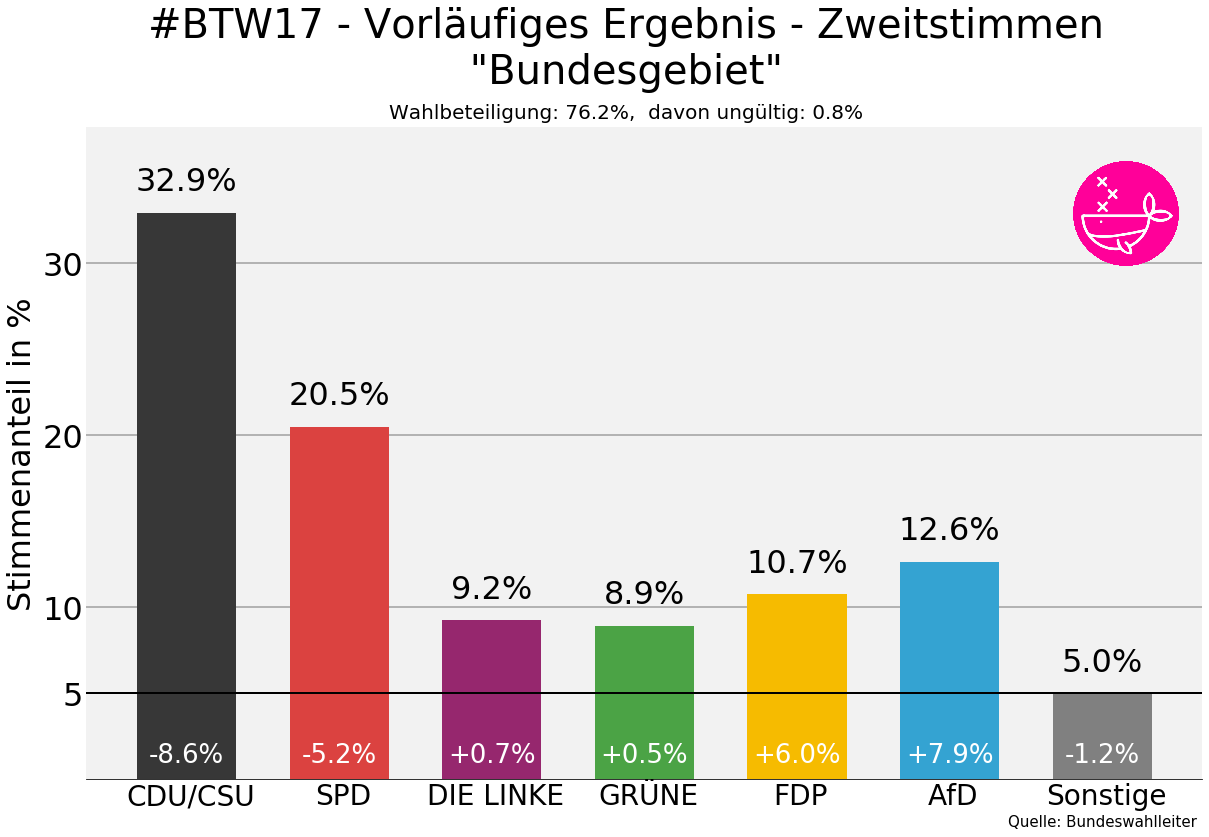

In [22]:
def plot_vote(wk_nummer):
    
    # get data for disctrict
    data = result(wk_nummer)
    
    values = []
    values13 = []
    label = []
    colors = []
    diff = []
    election17 = 'second17'
    election13 = 'second13'
    
    # which parties are to be presented
    top7 = ['CDU', 'CSU', 'SPD', 'DIE LINKE', 'GRÜNE', 'FDP', 'AfD']

    # create base table
    for party in top7:
        if data[election17][party] is not None:
            # round up to later. Otherwise you will end up with 33% instead of 32.9 (first add, then round)
            values.append(round(data[election17][party] * 100, 3))
            values13.append(round(data[election13][party] * 100, 3))
            key = party
            label.append(key)
            try:
                colors.append(color_dict[key])
            except:
                colors.append('grey')

            # consider the fact that you have CDU/CSU/UNION
            if label == ['CDU', 'CSU']:
                values = [sum(values)]
                values13 = [sum(values13)]
                label = ['CDU/CSU']
                colors = [color_dict[label[0]]]

    # create 'Sonstige
    diff = list(np.array(values) - np.array(values13))
    colors.append(color_dict['Sonstige'])
    label.append('Sonstige')
    values.append(round(100 - sum(values), 1))
    diff.append(round(values[-1] - (100 - sum(values13)), 1))

    #figure
    fig = plt.figure(figsize=(20, 12))
    ax = plt.gca()

    #settings bar plot
    index = np.arange(len(values))
    bar_width = 0.65
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='0.7', linestyle='-', linewidth=2)
    ax.bar(index, values, bar_width,
           color=colors
           )
    ax.set_facecolor('0.95')  # 0.95
    ax.set_ylim(0, max(values) + 5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # ticks
    plt.xticks(index + bar_width / 2 - 0.3, label, fontsize=28)
    ax.tick_params(axis=u'both', which=u'both', length=0)
    plt.yticks([5, 10, 20, 30, 40, 50, 60], fontsize=32)
    plt.ylabel('Stimmenanteil in %', fontsize=32)
    # bar plots + annotation
    for go in index:
        #round while printing is smart
        text = str(round(values[go],1)) + '%'
        ax.annotate(text, xy=(index[go], max(values[go] + 1.3, 5.5)), fontsize=32, ha='center')
        di = diff[go]
        text = str(round(diff[go],1)) + '%'
        if di >= 0:
            text = '+' + text
        if values[go] < 1.8:
            col = 'k'
            ylevel = 2.5
        else:
            col = 'white'
            ylevel = 1
        ax.annotate(text, xy=(index[go], ylevel), color=col, fontsize=26, ha='center')

    # 5% line
    plt.axhline(y=5, linewidth=2, color='k')
    ax.set_ylim(0, max(values) + 5)


    #### THIS PUTS IN A DATE STAMP TO GET RID OF "TEST PICTURES at 25.09.
    now = datetime.datetime.now()
    if now < datetime.datetime(2017, 9, 25, 3, 0, 0):
        t = plt.text(0.5, 0.50, 'TEST', transform=ax.transAxes, fontsize=180,ha='center')
        t.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))

    # add Wahltraud-Logo
    arr_hand = read_png('derwahl.png')
    imagebox = OffsetImage(arr_hand, zoom=.13)
    xy = [6.15, max(values) ]  # coordinates to position this image

    ab = AnnotationBbox(imagebox, xy,
                        xybox=(1, -1.),
                        frameon=False,
                        xycoords='data',
                        boxcoords="offset points")
    ax.add_artist(ab)



    # Add title
    plt.gcf().text(0.5, 0.93, '#BTW17 - Vorläufiges Ergebnis - Zweitstimmen\n \"'
                   + data['district'] +
                   '\" ', fontsize=40, ha='center')

    plt.gcf().text(0.5, 0.89, 'Wahlbeteiligung: ' +
                   str(round(data['voters'][election17] * 100, 1))
                   + '%,  davon ungültig: ' + str(round(data['voters_invalid'][election17] * 100, 1)) + '%',
                   ha='center', fontsize=20)
    # Add source
    plt.gcf().text(0.765, 0.07, 'Quelle: Bundeswahlleiter ', fontsize=15, ha='left')

    plt.show()

    # safe fig and close fig 
    #plt.savefig('../../static/bot/result_grafics/second_distric'+str(wk_nummer)+'.jpg', bbox_inches='tight')
    #plt.clf()
    #plt.close(fig)
    
plot_vote(999)